# RNA velocity projection
## anndataをもらって、修正されたvelocityを格納したanndataを返す。

In [1]:
# packages
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import hadamard, subspace_angles
from sklearn.decomposition import PCA

In [104]:
def projection(df_old_vel):
    # input: cells * genes dataframe
    # dartaframeに名前がついている場合注意
    df_new_vel = pd.DataFrame(index=[], columns=df_old_vel.columns)
    k = 50
    m_estimate = 2
    kNN = kneighbors_graph(df_old_vel, k, mode='connectivity', include_self=True)
    for idx,row in df_old_vel.iterrows():
        nn = kNN.indices[idx*k:idx*k+k]
        df = df_old_vel.iloc[nn,:] # kNN poins data df of idx
        mu = df.mean()
        f = lambda x: x - mu
        df_mu_centering = df.apply(f, axis=1)
        
        # Estimated tangent vector space (m_estimate-dimensional subspace)
        pca = PCA(n_components=m_estimate)
        pca.fit(df_mu_centering)
        TpM_est = pd.DataFrame(pca.components_).T
        # 推定された接ベクトル空間を構成する基底を列ベクトルにもつ dim(genes)*m_estimate matrix
        
        V = TpM_est.to_numpy()
        new_vel = np.dot(np.dot(V, V.T), row)
        df_new_vel = df_new_vel.append(pd.Series(new_vel, index=df_new_vel.columns), ignore_index=True)
    return df_new_vel

In [29]:
rna_velocity_projection(b)

,0,1,2,3
0,-0.306972,-0.330732,0.0,0.487214
1,-0.543639,0.370290,0.0,-0.694917
2,0.410854,0.681481,0.0,-0.376236
3,0.485999,-0.031193,0.0,0.788212
4,0.365637,-0.457316,0.0,-0.313312


## 以下、projectionの超球での検証（プログラムがあっているか）

In [33]:
def uni_dist_on_unit_sphere(n=1000):
    goldenRatio = (1 + 5**0.5) / 2
    i = np.arange(0, n)
    phi = 2 * np.pi * i / goldenRatio
    theta = np.arccos(1 - 2*(i+0.5)/n)
    x, y, z = np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)
    return x, y, z, phi, theta # [3 * n]

In [34]:
x,y,z,phi,theta = uni_dist_on_unit_sphere()

In [35]:
ls = pd.DataFrame([x,y,z]).T.to_numpy()
ls

array([[ 0.04471018,  0.        ,  0.999     ],
       [-0.05707349, -0.052284  ,  0.997     ],
       [ 0.00873164,  0.0994925 ,  0.995     ],
       ...,
       [ 0.04258895,  0.09033926, -0.995     ],
       [ 0.02295468, -0.07391943, -0.997     ],
       [-0.03861977,  0.02252806, -0.999     ]])

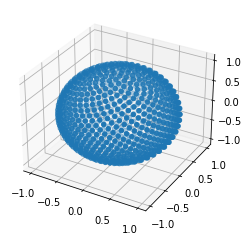

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x,y,z)
plt.show()

In [54]:
b, index, TpM_EST = rna_velocity_projection(pd.DataFrame(ls))
b

,0,1,2
0,-0.006392,-0.010255,0.000432
1,0.000120,-0.004382,-0.000204
2,-0.007684,-0.009351,0.001151
3,0.002717,-0.005356,-0.000665
4,-0.013027,0.001262,-0.001587
...,...,...,...
995,0.011888,-0.005474,0.001587
996,-0.005046,-0.003257,0.000665
997,0.001926,-0.011949,-0.001151
998,-0.002311,-0.003724,0.000204


In [55]:
TpM_EST

,0,1
0,-0.664194,-0.746544
1,0.745766,-0.665308
2,0.051769,0.006080


In [57]:
index

999

In [41]:
raw_data = pd.DataFrame(ls)

In [45]:
raw_data

,0,1,2
0,0.044710,0.000000,0.999
1,-0.057073,-0.052284,0.997
2,0.008732,0.099493,0.995
3,0.071865,-0.093736,0.993
4,-0.131816,0.023316,0.991
...,...,...,...
995,0.125608,-0.046278,-0.991
996,-0.109306,-0.044756,-0.993
997,0.042589,0.090339,-0.995
998,0.022955,-0.073919,-0.997


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# 基底ベクトルを指定して平面をプロットする関数
# axes：サブプロット
# v,w：基底ベクトル
# xrange,yrange,zrange：x軸,y軸,z軸の範囲
# vcolor,wcolor：基底ベクトルの色
# pcolor,alpha：平面の色,透明度

def bvector_plane(axes, v, w, xrange, yrange, zrange,
                  srange, trange,x,y,z,TpM_EST,
                  vcolor="red", wcolor="blue",
                  pcolor="green", alpha=0.2):

    # 軸ラベルの設定
    axes.set_xlabel("x", fontsize = 16)
    axes.set_ylabel("y", fontsize = 16)
    axes.set_zlabel("z", fontsize = 16)

    # 軸範囲の設定
    axes.set_xlim(xrange[0], xrange[1])
    axes.set_ylim(yrange[0], yrange[1])
    axes.set_zlim(zrange[0], zrange[1])

    # 格子点の作成
    s = np.arange(srange[0], srange[1], 0.2)
    t = np.arange(trange[0], trange[1], 0.2)
    ss, tt = np.meshgrid(s, t)

    # 基底ベクトルの線型結合
    xx = x + v[0]*ss + w[0]*tt
    yy = y + v[1]*ss + w[1]*tt
    zz = z + v[2]*ss + w[2]*tt

    # 平面をプロット
    ax.plot_surface(xx, yy, zz, color=pcolor, alpha=alpha)

    # 基底ベクトルをプロット
    axes.quiver(x,y,z, v[0], v[1], v[2],
                color=vcolor, length=1, arrow_length_ratio=0.2)
    
    axes.quiver(x,y,z, w[0], w[1], w[2],
                color=wcolor, length=1, arrow_length_ratio=0.2)
    
    # RNA velocityベクトルをプロット
    vec = [0.5,0.5,-1.0]
    axes.quiver(x,y,z, vec[0], vec[1], vec[2], color=pcolor, length=2, arrow_length_ratio=0.2)
    projected = np.dot(np.dot(TpM_EST, TpM_EST.T), vec)
    print(projected)
    axes.quiver(x,y,z, projected[0], projected[1], vec[2], color="orange", length=2, arrow_length_ratio=0.2)

[ 0.53883847  0.46551309 -0.00489754]


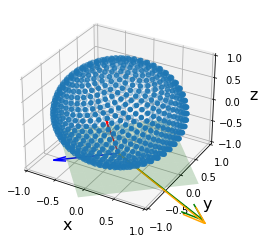

In [103]:
#df = df.reset_index().iloc[:,1:]
#df = df.iloc[nn,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
# ax.set_zlim(0,2)
#ax.scatter3D(df.iloc[:,0],df.iloc[:,1],df.iloc[:,2])
ax.scatter3D(raw_data.iloc[:,0],raw_data.iloc[:,1],raw_data.iloc[:,2])

e0 = TpM_EST.iloc[:,0]
e1 = TpM_EST.iloc[:,1]
#e2 = TpM_est.iloc[:,2]


# e0_ans = TpS2_normalized.iloc[:,0]
# e1_ans = TpS2_normalized.iloc[:,1]

srange = [-1,1]
trange = [-1,1]
xrange = [-1,1]
yrange = [-1,1]
zrange = [-1,1]
# srange = [-1,1]
# trange = [-1,1]
# xrange = [0,2]
# yrange = [0,2]
# zrange = [0,2]
#ax.scatter3D(df_pmu_centering.iloc[:,0],df_pmu_centering.iloc[:,1],df_pmu_centering.iloc[:,2])
bvector_plane(ax, e0,e1,xrange, yrange,zrange, srange,trange,raw_data.iloc[index,0],raw_data.iloc[index,1],raw_data.iloc[index,2], TpM_EST)
#bvector_plane(ax, e0_ans,e1_ans,xrange, yrange,zrange, srange,trange,df.iloc[0,0],df.iloc[0,1],df.iloc[0,2])

plt.show()

In [100]:
np.dot(np.dot(TpM_EST, TpM_EST.T), [0.5,-0.5,-1.0])

array([ 0.53748951, -0.53328909, -0.03946002])

In [101]:
TpM_EST

,0,1
0,-0.664194,-0.746544
1,0.745766,-0.665308
2,0.051769,0.006080


In [59]:
raw_data.iloc[index,:]

0   -0.038620
1    0.022528
2   -0.999000
Name: 999, dtype: float64

In [69]:
e1[0]

-0.7465438923973247